# RPZ Assignment: Convolutional Neural Networks

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

This lab consists of two parts. In the first part, you will build simple neural networks (NN) using only NumPy in order to get familiar with the principles typically hidden behind commonly used frameworks. 

The first part follows the traditional RPZ assignment style and includes various links for further explanations. You may want to use the link in case the concept is not clear of if you want to learn more. Many more useful links are included at the end of this notebook.

The second part is intentionally formulated less precisely, giving you freedom to explore the topic. You will work in the PyTorch framework, a highly optimized library for training neural networks. Since it is impossible to cover everything in a single notebook, we provide basic training procedures and encourage you to learn by solving simple tasks.

Finally, there is a challenge! Passing Part 2 shouldn’t be too difficult, but can you outperform other RPZ students on a hidden test set? We offer many bonus points and enough time to experiment and learn. There is no better way to learn PyTorch than trying to solve a simple problem!

In [1]:
%load_ext autoreload
%autoreload 2

from numpy_nn import *
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy.testing as testing


# param for visualisation
n_data = 1001

## Part 1: Implementing a simple neural network by hand

We start by implementing a few simple layers in pure NumPy to get better understanding of what is going on in the machine learning frameworks like PyTorch, TensorFlow, etc.

Recall, that a neural network is an acyclic graph with individual nodes being either simple Perceptrons (with non-linearity) or other 'layers'. A layer is an object which has two main functions: (i) it can pass the data forward during the prediction/classification phase -- implemented in `layer.forward` method, and (ii) it computes gradients with respect to (w.r.t.) its inputs and parameters which are then passed backward during back-propagation training -- implemented in `layer.backward` method. This allows to chain many layers into very large graphs and then compute efficiently the gradient of the loss function w.r.t. every parameter. The forward pass propagates the input data through the `forward` calls in each layer sequentially from the first to the last layer. Then, starting at the last layer, the gradients are propagated backwards in the graph (with the `backward` function) down to all parameters. The basic example of backpropagation was given in the lecture. For a more detailed overview see e.g. the respective [lecture](https://youtu.be/XhduJETbSMk) of the Deep Learning course or the [lecture by Karpathy](https://youtu.be/i94OvYb6noo). After all the gradients are computed, we update the network parameters by a (stochastic) gradient descent (SGD) step and repeat the procedure.

You will see that out of all layers which we consider, only the fully-connected layer (or linear layer as we call it) has some trainable parameters.
During training, SGD updates the network parameters using partial derivatives of the loss w.r.t. the parameters.
For a layer with trainable parameters, we also need to implement a method `layer.grads` which returns the gradients of the loss w.r.t. its parameters computed in `layer.backward`.

### Fully-connected (Linear) layer

In its `forward` method, the `Linear` layer implements the function $f(\mathbf{x}) = \mathbf{x} \mathbf{W} + \mathbf{b}$ (this is PyTorch-style definition, note that it differs from the one in lecture: Wx + b). <br> **Hint**: You may need to store the inputs $x$ for later use in the `backward` method.

In the `backward` method, the gradients of the layer w.r.t. $\mathbf{W}$, $\mathbf{b}$ and the layer input are computed. The method returns only the gradient of the loss w.r.t. the layer's input.

Both `forward` and `backward` methods must work with several data samples stacked together in a tensor (these are called batches or minibatches).
Make sure that you **check your shapes against the docstring specifications!** <br>
Remember, **CHECK YOUR SHAPES!** <br>
Reshaping, adding extra dimensions or transposing the arrays may come handy (you might want to check an old [NumPy - HOW TO thread](https://cw.felk.cvut.cz/forum/thread-4609.html) at the forum).

Make sure that the gradients' computation is working for batched data and their **shapes are the same as the docstring tells you**.  If you are getting a weird error in BRUTE, it is very likely that your **shapes are wrong!**

In [2]:
# set layer params
input_dim = 3
output_dim = 2

# create instance of linear layer
linear_layer = Linear(input_dim, output_dim)

# set weights and bias of linear layer (for testing purposes)
linear_layer.W = np.array([[ 1.,   0.6],
                           [ 0.2, -0.2],
                           [-0.6, -1. ]])
linear_layer.b = np.array([[-0.5, 0.5]])

# create sample input data
batch_size = 2
x_linear = np.array([[-2.,  -1.2, -0.4],
              [ 0.4,  1.2,  2. ]])

# forward pass of linear layer
forward_output = linear_layer.forward(x_linear)

# check if the result is correct
testing.assert_array_almost_equal([[-2.5, -0.06], [-1.06, -1.5 ]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Now visualize the layer output over a range of inputs.

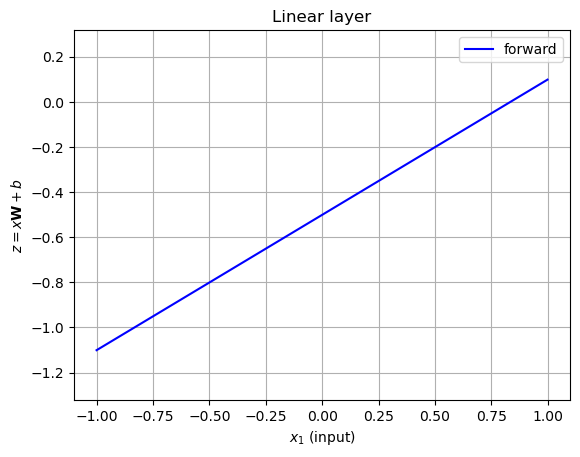

In [3]:
# set data for visualization
x_visualization = np.linspace(-1, 1, n_data * input_dim).reshape(n_data, input_dim)

# forward pass of linear layer
forward_output = linear_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization[:, 0], forward_output[:, 0])], 
             ['forward'], 
             title='Linear layer',
             xlabel='$x_1$ (input)', 
             ylabel='$z = x\\mathbf{W} + b$', 
             axis='equal', 
             grid=True, 
             linestyle='b', 
             save_filepath='layer_linear_forward.png')

The forward pass works, so let's implement the backward pass of the `Linear` layer.

In [4]:
# run forward pass to make sure variables stored in the layer are up to date
_ = linear_layer.forward(x_linear)

# Define gradient of loss wrt layer output
dL_wrt_output = np.array([[1., 1.33333333],
                          [1.66666667, 2. ]])

# backward pass of linear layer (computation of gradient of loss wrt layer input)
dL_wrt_x = linear_layer.backward(dL_wrt_output)

# Check if the results are correct
testing.assert_array_almost_equal([[1.8, -0.06666667, -1.93333333],
                                   [ 2.86666667, -0.06666667, -3.]],
                                  dL_wrt_x,
                                  decimal=6,
                                  err_msg='The gradient values returned from the backward pass are incorrect.')
testing.assert_array_almost_equal(
    [[[-2., -2.66666667],
    [-1.2, -1.6],
    [-0.4, -0.53333333]],
    [[ 0.66666667, 0.8],
    [ 2., 2.4  ],
    [ 3.33333333,  4.0 ]]], 
    linear_layer.dL_wrt_W, decimal=6, err_msg='The W parameter gradient values populated by the backward pass are incorrect.')

testing.assert_array_almost_equal(
    [[[1., 1.33333333]],
    [[1.66666667, 2.]]],
    linear_layer.dL_wrt_b, decimal=6, err_msg='The b parameter gradient values populated by the backward pass are incorrect.')


### Rectified Linear Unit (ReLU) layer

ReLU is a commonly used non-linear layer which computes $f(\mathbf{x}) = \text{max}(\mathbf{0}, \mathbf{x})$. Both `forward` and `backward` methods are significantly simpler as the layer has no parameters.

Make sure it works for arbitrarily shaped inputs (even 3D, 4D, or more-D)!


In [5]:
# create instance of ReLU layer
relu_layer = ReLU()

# create sample input data
x_relu = np.array([[-2.,  -1.2, -0.4], 
                   [0.4,  1.2,  2.]])

# forward pass of ReLu layer
forward_output = relu_layer.forward(x_relu)

# check if the result is correct
testing.assert_array_almost_equal([[0, 0, 0], [0.4,  1.2,  2.]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Now visualize the layer output over a range of inputs.

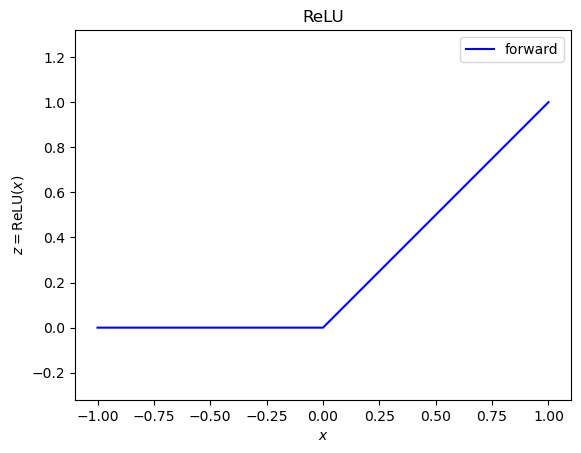

In [6]:
# set data
x_visualization = np.linspace(-1,1,n_data)

# compute the forward pass
forward_output = relu_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization, forward_output)], 
             ['forward'], 
             title='ReLU', 
             axis='equal', 
             xlabel='$x$', 
             ylabel='$z=$ReLU$(x)$', 
             linestyle='b', 
             Tgrid=True, 
             save_filepath='layer_relu_forward.png')

Let's implement the backward pass of the `ReLU` layer. The `backward` method computes only the gradient of the loss w.r.t. the layer inputs this time.

In [7]:
# run forward pass to make sure variables stored in the layer are up to date
_ = relu_layer.forward(x_relu)

# Define sample gradient of loss wrt layer output
dL_wrt_output_relu = np.array([[-3.,  1.2, -0.5], 
                               [ -0.4,  2.2,  3. ]])


# backward pass of ReLU layer (computation of gradient of loss wrt layer input)
dL_wrt_x_relu = relu_layer.backward(dL_wrt_output_relu)

# Check if the results are correct
testing.assert_array_almost_equal([[ 0.,   0.,   0. ],
                                   [-0.4,  2.2,  3. ]],
                                   dL_wrt_x_relu,
                                   decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Sigmoid layer

You already know the logistic sigmoid from the logistic regression lab.  The `Sigmoid` layer implements the function $f(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}}}$.  As in the ReLU layer, there are no parameters in the `Sigmoid` layer. The `backward` method gain only computes the gradient of the loss w.r.t. the layer inputs.

In [8]:
# create instance of Sigmoid layer
sigmoid_layer = Sigmoid()

# create sample input data
x_sigmoid = np.array([[-2.,  -1.2, -0.4], 
                      [ 0.4,  1.2,  2. ]])

# forward pass of Sigmoid layer
forward_output = sigmoid_layer.forward(x_sigmoid)

# check if the result is correct
testing.assert_array_almost_equal([[0.119203, 0.231475, 0.401312],
                                  [0.598688, 0.768525, 0.880797]], forward_output, decimal=6, err_msg='The values returned from the forward pass are incorrect.')

Again, visualize the output over a range of inputs.

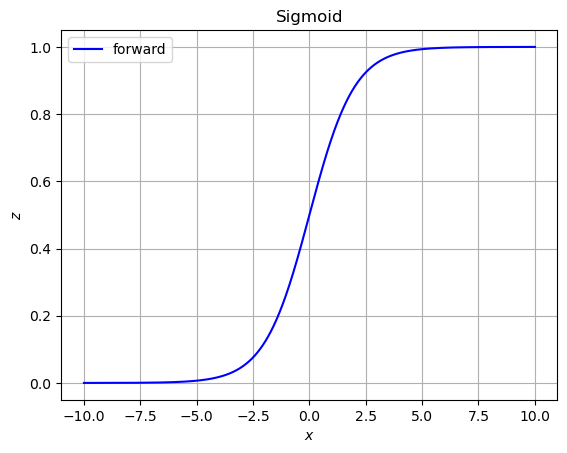

In [9]:
# set data
x_visualization = np.linspace(-10,10,n_data)

# compute forward pass sigmoid
forward_output = sigmoid_layer.forward(x_visualization)

# visualize results
visualize_xy([(x_visualization, forward_output)], 
             ['forward'], 
             title='Sigmoid', 
             xlabel='$x$', 
             ylabel='$z$', 
             grid=True, 
             linestyle='b', 
             save_filepath='layer_sigmoid_forward.png')

Now implement the backward pass of the `Sigmoid` layer.

In [10]:
# run forward pass to make sure variables stored in the layer are up to date
_ = sigmoid_layer.forward(x_sigmoid)

# Define sample gradient of loss wrt layer output
dL_wrt_output_sigmoid = np.array([[-3.,  1.2, -0.5], 
                                  [ -0.4,  2.2,  3. ]])

# compute backward pass of Sigmoid layer
dL_wrt_x_sigmoid = sigmoid_layer.backward(dL_wrt_output_sigmoid)

# Check if the results are correct
testing.assert_array_almost_equal([[-0.314981,  0.213473, -0.12013 ],
                                   [-0.096104,  0.391368,  0.314981]],
                                  dL_wrt_x_sigmoid,
                                  decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Squared Error loss

The final ingredient of our network is the **loss function**, which compares actual network output $\mathbf{y}$ with the expected output $\mathbf{y}_{gt}$. In our network, we will use Squared Error (SE) loss, which is computed as $L(\mathbf{y}, \mathbf{y}_{gt}) = (\mathbf{y}-\mathbf{y}_{gt})^2$. Start by implementing its `forward` method.

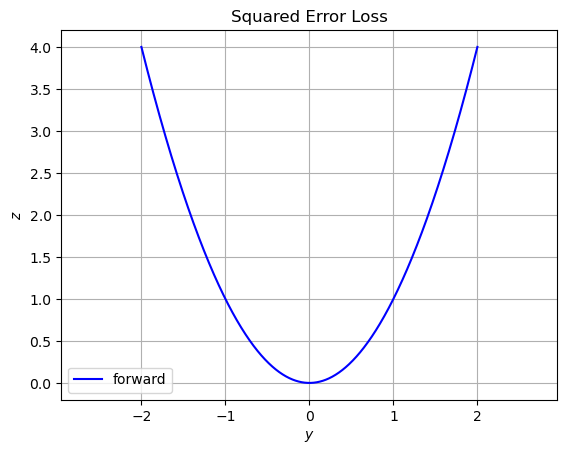

In [11]:
# set input data and ground truth data
y = np.linspace(-2, 2, 1001)
y_gt = 0 * y

# create instance of Squared Error Loss layer
se_layer = SE()

# compute SE loss
loss_se = se_layer.forward(y, y_gt)

# visualize results
visualize_xy([(y, loss_se)], 
             ['forward'], 
             title='Squared Error Loss', 
             axis='equal', 
             xlabel='$y$', 
             ylabel='$z$', 
             linestyle='b', 
             grid=True, 
             save_filepath='layer_se_forward.png')

The `backward` method computes the gradient of the loss only w.r.t. the input $\mathbf{y}$.

In [12]:
# set gradient of loss wrt layer output
n_data_bw = 9
dL_wrt_output_se = np.linspace(-10, 10, n_data_bw)

# set forward pass data and computation
y = np.linspace(-5, 5, n_data_bw)
y_gt = 0.5 * y
_ = se_layer.forward(y, y_gt)

# compute backward pass ReLU
dL_wrt_y = se_layer.backward()

# Check if the results are correct
testing.assert_array_almost_equal([-5., -3.75, -2.5, -1.25, 0., 1.25, 2.5, 3.75, 5.],
                                  dL_wrt_y,
                                  decimal=6, err_msg='The gradient values returned from the backward pass are incorrect.')

### Training the network

Your task is to train the network for a binary classification of two selected classes (digits) from the MNIST dataset.


Start by loading the data for training and validation.

In [13]:
class_a = 1
class_b = 7

(X_trn_full, y_trn_full), (X_tst, y_tst) = load_data('full-mnist.npz',
                                           class_a,
                                           class_b)

N_trn_full, D = X_trn_full.shape
assert D == 28 * 28
assert y_trn_full.shape == (N_trn_full, 1)

# Shuffle the data
trn_indices = np.arange(N_trn_full)
np.random.shuffle(trn_indices)
X_trn_full = X_trn_full[trn_indices, :]
y_trn_full = y_trn_full[trn_indices, :]

Define the network structure (the model) and the training configuration (also known as hyper-parameters).

Make sure to experiment with the hyper-parameter settings (e.g.: Slow training? Try increasing `learning_rate`. No convergence? Try decreasing `learning_rate`) and the `model` network architecture above. A typical model has several layers organised as Linear -> ReLU -> Linear -> ReLU -> ... -> Linear -> Sigmoid, but many other options are possible.
  - Does adding more fully-connected layers help?
  - Does having more output units in the fully-connected layer help?
  - What activation functions work the best?
  - Experiment with the batch size and watch how it influences the training.
  - Feel free to implement also other layers and non-linearities.

In [14]:
model = [Linear(D, 5), ReLU(), Linear(5, 1), Sigmoid()]
trn_head = SE()

learning_rate = 0.01
batch_size = 8
N_epochs = 90
validation_set_fraction = 0.5

**And start the training!**

*You do not need to modify the following training block of code, but make sure you read it carefully and that you understand it.*

In [15]:
print_each = 5 # loss printing setting - (you can modify this)

# Split into train/val
idx_split = int(np.round(N_trn_full * validation_set_fraction))

X_val = X_trn_full[:idx_split, :]
X_trn = X_trn_full[idx_split:, :]
N_trn = X_trn.shape[0]
N_val = X_val.shape[0]

y_val = y_trn_full[:idx_split, :]
y_trn = y_trn_full[idx_split:, :]

# The training loop
model_best_params = []
trn_losses = []
val_losses = []
best_val_loss_epoch = 0

batch_count = int(np.ceil(N_trn / batch_size))
for epoch in range(N_epochs):
    try:
        cumulative_epoch_trn_loss = 0 # just for reporting progress
        time_start = time.time()
        for batch_i in range(batch_count):
            # load the minibatch:
            batch_idx = range(batch_i * batch_size,
                              min(N_trn, (batch_i + 1) * batch_size))

            activation = X_trn[batch_idx]

            # forward pass:
            for layer in model:
                activation = layer.forward(activation)

            loss = trn_head.forward(activation, y_trn[batch_idx])
            trn_loss = loss.mean()

            cumulative_epoch_trn_loss += trn_loss

            # backward pass:
            grad_output = trn_head.backward()
            for layer in reversed(model):
                grad_output = layer.backward(grad_output)

            # Update the weights with gradient descent
            for layer in model:
                for param_name, param_value in layer.params().items():
                    param_value -= learning_rate * layer.grads()[param_name].mean(axis=0) # mean across the minibatch

        # validation
        activation = X_val.copy()
        for layer in model:
            activation = layer.forward(activation)
        val_losses.append(trn_head.forward(activation, y_val).mean())

        # remember the best model so far
        if len(val_losses) == 0 or val_losses[-1] < val_losses[best_val_loss_epoch]:
            best_val_loss_epoch = epoch
            model_best_params = [copy.deepcopy(layer.params()) for layer in model]

        trn_losses.append(cumulative_epoch_trn_loss / batch_count)
        if (epoch+1) % print_each == 0 or epoch == 0:
            print("[{:04d}/{:04d}][TRN] MSE loss {:2f} ({:.1f}s)".format(epoch+1, N_epochs, trn_losses[-1], time.time() - time_start))
            print("[{:04d}/{:04d}][VAL] MSE loss {:2f}".format(epoch+1, N_epochs, val_losses[-1]))
    except KeyboardInterrupt:
        print('Early exit')
        break

[0001/0090][TRN] MSE loss 0.073623 (0.1s)
[0001/0090][VAL] MSE loss 0.011226
[0005/0090][TRN] MSE loss 0.005568 (0.2s)
[0005/0090][VAL] MSE loss 0.004834
[0010/0090][TRN] MSE loss 0.004037 (0.2s)
[0010/0090][VAL] MSE loss 0.003882
[0015/0090][TRN] MSE loss 0.003482 (0.2s)
[0015/0090][VAL] MSE loss 0.003575
[0020/0090][TRN] MSE loss 0.003121 (0.1s)
[0020/0090][VAL] MSE loss 0.003423
[0025/0090][TRN] MSE loss 0.002820 (0.2s)
[0025/0090][VAL] MSE loss 0.003332
[0030/0090][TRN] MSE loss 0.002557 (0.2s)
[0030/0090][VAL] MSE loss 0.003268
[0035/0090][TRN] MSE loss 0.002331 (0.2s)
[0035/0090][VAL] MSE loss 0.003221
[0040/0090][TRN] MSE loss 0.002138 (0.2s)
[0040/0090][VAL] MSE loss 0.003189
[0045/0090][TRN] MSE loss 0.001972 (0.2s)
[0045/0090][VAL] MSE loss 0.003166
[0050/0090][TRN] MSE loss 0.001817 (0.2s)
[0050/0090][VAL] MSE loss 0.003148
[0055/0090][TRN] MSE loss 0.001676 (0.2s)
[0055/0090][VAL] MSE loss 0.003127
[0060/0090][TRN] MSE loss 0.001569 (0.2s)
[0060/0090][VAL] MSE loss 0.003115

Plot training outcome

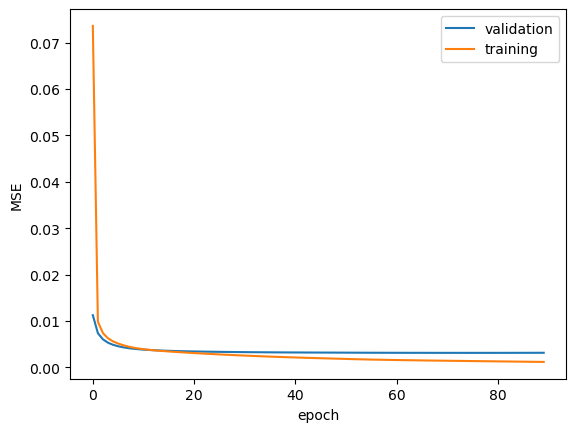

In [16]:
visualize_data([val_losses, trn_losses], legend=['validation', 'training'], xlabel='epoch', ylabel='MSE', save_filepath='numpy_nn_training.png')

Use the best model to classify the test set and show the results

Best VAL model loss 0.0031 at epoch #74.
[TST] MSE loss 0.0054
[TST] error 0.0060


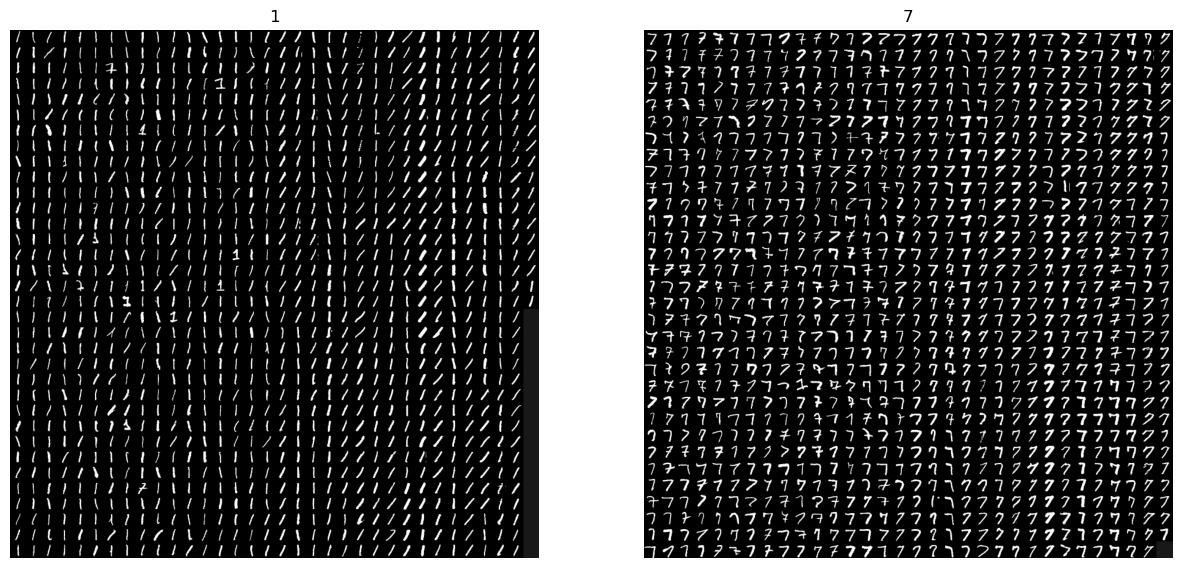

In [17]:
# TST load best model
print('Best VAL model loss {:.4f} at epoch #{:d}.'.format(val_losses[best_val_loss_epoch], best_val_loss_epoch))
for layer_id in range(len(model_best_params)):
    for key, value in model_best_params[layer_id].items():
        model[layer_id].params()[key] = value

# TST forward pass
activation = X_tst
for layer in model:
    activation = layer.forward(activation)
y_hat = (activation > 0.5).astype(int)

loss = trn_head.forward(activation, y_tst)
print("[TST] MSE loss {:.4f}".format(loss.mean()))

test_error = np.mean(y_hat != y_tst)
print("[TST] error {:.4f}".format(test_error))

plt.figure(figsize=(15, 10))
plt.title('NN classification: test error {:.4f}'.format(test_error))
show_classification(X_tst.transpose(1, 0).reshape(28, 28, -1), y_hat.squeeze(), '{}{}'.format(class_a,
                                                                                              class_b))
plt.savefig('numpy_nn_classification.png')
plt.show()

## Part 2: Convolutional Neural Network (CNN) in PyTorch

**In this part, we will be using PyTorch framework for the first time in this course. Ensure you have PyTorch installed as per the [course instructions](https://cw.fel.cvut.cz/wiki/courses/be5b33rpz/labs/python_development#python).**
 
While our simple NumPy NN from the previous part works well for basic two-digit classification, it quickly becomes inefficient for more complex tasks. For such cases, highly optimized public libraries like PyTorch are better suited.  PyTorch is currently one of the most popular frameworks for building CNNs - [PyTorch](https://pytorch.org). Building a neural network using PyTorch is straightforward - it provides a wide range of prebuilt layers, allowing you to process data through the network as you would in plain NumPy.

Using PyTorch should feel familiar compared to NumPy, but with the added benefit of having most layers already implemented for you. Reading through the `pytorch_cnn.py` template should give you a solid introduction to PyTorch basics.

We also recommend the official documentation (e.g. [PyTorch 2.3 Conv2d documentation](https://pytorch.org/docs/2.3/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)) and the  tutorials for further guidance:
  * Official [PyTorch introduction course](https://pytorch.org/tutorials/beginner/basics/intro.html). There are step-by-step tutorials, documentation and a possibility of using Google Colab notebooks for learning PyTorch.
  * Official [YouTube playlist](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN) with PyTorch tutorials by Brad Heintz.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from pytorch_cnn import *
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Linear classifier, multinomial logistic regression and stochastic gradient descent on FashionMNIST

Let's start with a simple one layer fully-connected network. You should now understand how backpropagation works under the hood after the first part of this assignment. Here we extend the binary classification to the multi-class one. Fortunately, this is quite easy using the multinomial logistic regression model. Simply, the predictive probabilities of classes are computed by `softmax` instead of sigmoid:

$$p(y{=}k|s) = {\rm softmax}(s)_k = \frac{e^{s_k}}{\sum_j e^{s_j}},$$

where $s$ is a vector of scores (one per class) computed by the preceding layers of the network. For the purpose of numerical stability it is convenient to adopt the convention that the network should output log probabilities, and use the function `log_softmax` as in the template.

Below we provide a code for training a simple one-layer network `FCNet` with log-softmax. It is trained using the stochastic gradient descent to minimize the negative log likelihood loss (NLL).

**Tasks:**
  - Train the `FCNet` network on FashionMNIST data
  - Add another fully-connected layer with 1000 hidden units and with `Sigmoid` non-linearity. Do you get better results?
  - Try to add more layers. Does the network improve with more and more layers?
  - How many weights do you learn in each case?
  - Try to substitute the sigmoid non-linearity with Rectified Linear Unit (ReLU). It helps to avoid the [vanishing gradient problem](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b#.jusk4zkst).
  - Experiment with the number of layers, number of hidden units and try to get the best possible result.

[TRN] Train epoch: 1, batch: 0	Loss: 2.3569
[TRN] Train epoch: 1, batch: 100	Loss: 0.6066
[TRN] Train epoch: 1, batch: 200	Loss: 0.4213
[TRN] Train epoch: 1, batch: 300	Loss: 0.6446
[VAL] Validation accuracy: 83.33%
[TRN] Train epoch: 2, batch: 0	Loss: 0.1556
[TRN] Train epoch: 2, batch: 100	Loss: 0.5007
[TRN] Train epoch: 2, batch: 200	Loss: 0.9914
[TRN] Train epoch: 2, batch: 300	Loss: 0.5869
[VAL] Validation accuracy: 83.83%
[TRN] Train epoch: 3, batch: 0	Loss: 0.8184
[TRN] Train epoch: 3, batch: 100	Loss: 0.3371
[TRN] Train epoch: 3, batch: 200	Loss: 0.6868
[TRN] Train epoch: 3, batch: 300	Loss: 0.3173
[VAL] Validation accuracy: 81.00%
[TRN] Train epoch: 4, batch: 0	Loss: 0.2729
[TRN] Train epoch: 4, batch: 100	Loss: 0.2661
[TRN] Train epoch: 4, batch: 200	Loss: 0.4993
[TRN] Train epoch: 4, batch: 300	Loss: 0.4890
[VAL] Validation accuracy: 82.17%
[TRN] Train epoch: 5, batch: 0	Loss: 0.2910
[TRN] Train epoch: 5, batch: 100	Loss: 0.4458
[TRN] Train epoch: 5, batch: 200	Loss: 0.4831


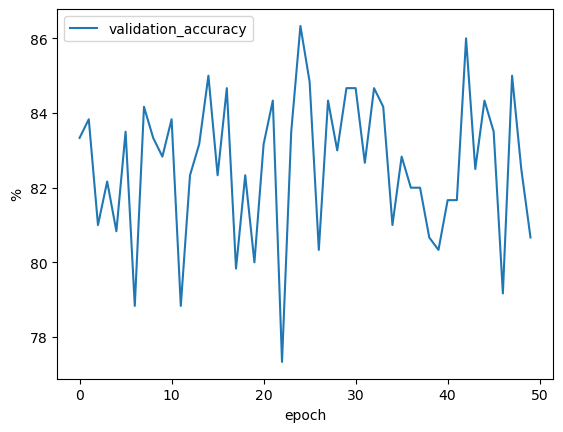

In [ ]:
learning_rate = 0.001
epochs = 50
batch_size = 16

dataset = datasets.FashionMNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())


trn_size = int(0.09 * len(dataset))
val_size = int(0.01 * len(dataset))
add_size = len(dataset) - trn_size - val_size  # you don't need ADDitional dataset to pass

trn_dataset, val_dataset, add_dataset = torch.utils.data.random_split(dataset, [trn_size,
                                                                                val_size,
                                                                                add_size])
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)


device = torch.device("cpu")
model = FCNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

validation_accuracies = []
for epoch in range(1, epochs + 1):
    # training
    model.train()
    for i_batch, (x, y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        net_output = model(x)
        loss = F.nll_loss(net_output, y)
        loss.backward()
        optimizer.step()

        if i_batch % 100 == 0:
            print('[TRN] Train epoch: {}, batch: {}\tLoss: {:.4f}'.format(
                epoch, i_batch, loss.item()))

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            prediction = classify(model, x)
            correct += prediction.eq(y).sum().item()
    val_accuracy = correct / len(val_loader.dataset)
    validation_accuracies.append(100. * val_accuracy)
    print('[VAL] Validation accuracy: {:.2f}%'.format(100 * val_accuracy))


visualize_data([validation_accuracies], legend=['validation_accuracy'], xlabel='epoch', ylabel='%', save_filepath='pytorch_fcnet_training.png')

### Convolutional Neural Network on FashionMNIST

One of the main disadvantages of using the fully-connected layers on images is that they do not take into account the spatial structure of the image. Imagine that you randomly perturb the spatial arrangement of image pixels (same way in both the training and test data) and re-train the fully-connected network. These perturbed images become completely unlearnable for humans, since humans make a prior assumption about the spatial arrangement. Nevertheless, the expected test error of the re-trained fully-connected network on this randomly perturbed dataset will be the same, since it does not make any assumptions and learns the spatial arrangement from the scratch from the perturbed training data. When we learn on images, the architecture of the network should reflect the particular spatial arrangement.

We impose the spatial arrangement by introducing the [convolutional layers](http://cs231n.github.io/convolutional-networks/#conv). You may imagine the convolution as shifting a local template (often called a convolution kernel or a local receptive field) over the image and computing its response for every single position in the image. For example, when the input image is 28x28, and we compute convolution with 5x5 kernel, then the resulting response image will be 24x24 (unless we pad the image with zeros). When learned, these templates often corresponds to edge or corner detectors in early layers.

Illustration for 3x3 kernel, single input and single output channel ([source](https://mlnotebook.github.io/post/CNN1/)):

<img src="assets/singlechannel-conv.gif" width="400">

Illustration for 3x3 kernel, padding 1, stride 2, three input and two output channels ([source](https://cs231n.github.io/assets/conv-demo/index.html)):

<img src="assets/multichannel-conv.gif" width="600">

Another disadvantage of the fully-connected layers is that the number of parameters grows quickly with new layers. This means significantly more parameters need to be learned and thus more data is needed to avoid overfitting.

**Tasks:**
  - Train a CNN with one convolutional layer (3x3 kernel) followed by a ReLU non-linearity and a fully connected layer with log-softmax output (see `SimpleCNN` provided in the template).  Notice that the kernel is not evaluated at every position but at every second one only (stride=2). This makes the second layer smaller while keeping most of the information present (as nearby convolutions result in similar values). We also added padding=1, which adds zeros to the image before computing the convolution. This way, the size of the output stays the same when stride=1 and becomes half when stride=2.
  - Are you getting better results than with fully connected networks? Does taking into account the spatial arrangement help?
  - How many parameters are you learning now? Compare this to the case of the two layered fully connected network.
  - Add one more convolutional layer with ReLU (again with stride=2).
  - To train a CNN one still needs a lot of data as the number of parameters being estimated is large. To avoid over-fitting, two another techniques are commonly used: [max pooling](http://cs231n.github.io/convolutional-networks/#pool) and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Substitute the stride=2 with stride=1 and add max-pooling. Add a dropout layer before the fully connected layer.
  - In order to overcome the baseline performance and get 6 points implement your network in `MyNet` - exploiting the following techniques should be sufficient:
    * longer training, [one cycle schedule](https://sgugger.github.io/the-1cycle-policy.html) or other [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
    * increasing the number of layers
    * change the number and size of the convolutional kernels
    * [data augmentation](https://pytorch.org/vision/stable/transforms.html) to get more data

**Note** that some students prefer training their PyTorch network in [Google Colab](https://colab.research.google.com) cloud using GPU rather than on their own PCs. There is also a [FEL CTU GPU cluster](https://gpu.fel.cvut.cz/wiki/) available for students. However, for the basic training you should be fine (even though a bit slower) with CPU.

In [3]:
# Validate that the MyNet works with correct inputs and output dimensions

batch_size = 64

some_input = torch.rand(batch_size, 1, 28, 28, requires_grad=True)   # Input will be a tensor of size BxCxHxW, which collects gradients for backpropagation
model = MyNet() # Initialise our network
network_output = model(some_input)

# Validate that the network outputs tensors of correct format
assert torch.is_tensor(network_output), 'The network has to output a PyTorch tensor'
assert network_output.requires_grad, 'The output has to collect gradients for backpropagation too'
testing.assert_array_equal(network_output.shape, [batch_size, 10], 'The network should output a tensor of dimensions BxK, where K = 10 classes.')

Start the training and plot the training progress.

[TRN] Train epoch: 1, batch: 0	Loss: 2.3555
[VAL] Validation accuracy: 48.50%
[TRN] Train epoch: 2, batch: 0	Loss: 1.7553
[VAL] Validation accuracy: 66.00%
[TRN] Train epoch: 3, batch: 0	Loss: 1.5004
[VAL] Validation accuracy: 72.50%
[TRN] Train epoch: 4, batch: 0	Loss: 1.2883
[VAL] Validation accuracy: 72.67%
[TRN] Train epoch: 5, batch: 0	Loss: 1.1045
[VAL] Validation accuracy: 74.50%
[TRN] Train epoch: 6, batch: 0	Loss: 1.1615
[VAL] Validation accuracy: 76.00%
[TRN] Train epoch: 7, batch: 0	Loss: 1.1061
[VAL] Validation accuracy: 77.17%
[TRN] Train epoch: 8, batch: 0	Loss: 0.9003
[VAL] Validation accuracy: 77.33%
[TRN] Train epoch: 9, batch: 0	Loss: 0.8336
[VAL] Validation accuracy: 77.67%
[TRN] Train epoch: 10, batch: 0	Loss: 0.8218
[VAL] Validation accuracy: 78.00%
[TRN] Train epoch: 11, batch: 0	Loss: 0.7979
[VAL] Validation accuracy: 78.50%
[TRN] Train epoch: 12, batch: 0	Loss: 0.6458
[VAL] Validation accuracy: 78.83%
[TRN] Train epoch: 13, batch: 0	Loss: 0.7141
[VAL] Validation

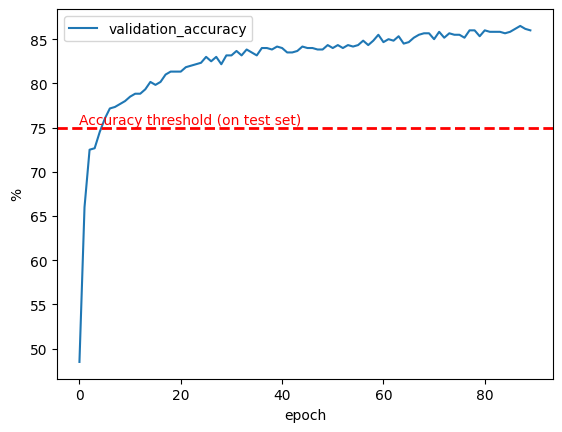

In [5]:
learning_rate = 0.001
epochs = 90

dataset = datasets.FashionMNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())

trn_size = int(0.09 * len(dataset))
val_size = int(0.01 * len(dataset))
add_size = len(dataset) - trn_size - val_size  # you don't need ADDitional dataset to pass

trn_dataset, val_dataset, add_dataset = torch.utils.data.random_split(dataset, [trn_size,
                                                                                val_size,
                                                                                add_size])
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

device = torch.device("cuda")
model = MyNet().to(device)


optimizer = optim.SGD(model.parameters(), lr=learning_rate)


validation_accuracies = []
for epoch in range(1, epochs + 1):
    # training
    model.train()
    for i_batch, (x, y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        net_output = model(x)
        loss = F.nll_loss(net_output, y)
        loss.backward()
        optimizer.step()

        if i_batch % 100 == 0:
            print('[TRN] Train epoch: {}, batch: {}\tLoss: {:.4f}'.format(
                epoch, i_batch, loss.item()))

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            prediction = classify(model, x)
            correct += prediction.eq(y).sum().item()
    val_accuracy = correct / len(val_loader.dataset)
    validation_accuracies.append(100. * val_accuracy)
    print('[VAL] Validation accuracy: {:.2f}%'.format(100 * val_accuracy))


print('Training completed, final accuracy: {:.2f}%'.format(100 * val_accuracy))
torch.save(model.state_dict(), "model.pt")

visualize_data([validation_accuracies], legend=['validation_accuracy'], xlabel='epoch', ylabel='%', save_filepath='pytorch_cnn_training.png', hline=75.0, hlinelabel='Accuracy threshold (on test set)')

Your submitted `MyNet` network will be automatically evaluated by the [upload system](https://cw.felk.cvut.cz/brute/). __Your network needs to perform better than the baseline 75% accuracy on the test set for you to pass this lab.__ 

Note that the accuracy on the test set (which is private and is only used by the evaluation server) might be slightly different (typically lower) than the observed validation accuracy. So you better achieve significantly better accuracy on the validation set. You are supposed to prepare your network using your validation set, not the test set on the server. The number of uploads is limited to 100 attempts by BRUTE, but try to keep it even smaller.

### Finetuning on Dogs-and-Cats

The problem we are solving is often more difficult and requires a complex model (many layers, a lot of parameters), but the dataset size is limited (e.g. it is difficult to collect and annotate enough data like in medical applications). Training a CNN from scratch in this case often results in a poorly performing model. Try a modification of your MyNet or basically any other architecture on the **Dogs-and-Cats** dataset available in `dogs_and_cats.zip`. You may use the following data loader to read the images in your training loop:

In [9]:
from torchvision.datasets import ImageFolder

# train_transform = transforms.Compose([
#     transforms.Resize((96, 96)),                     
#     transforms.RandomHorizontalFlip(),               
#     transforms.RandomRotation(20),                   
#     transforms.RandomResizedCrop(384),                
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
#     transforms.ToTensor(),                           
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
# ])

train_transform=transforms.Compose([
        transforms.Resize((96, 96)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
])

dataset = ImageFolder(
    root='./dogs_and_cats',
    transform=train_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

trn_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

**Our best training from scratch result with a custom architecture and all the tricks we know so far is 60% test accuracy. If you manage to get close or even over, let us know!**

However, a better approach (when applicable) is to initialize the weights by some network pretrained on a bigger dataset (e.g. [ImageNet](https://image-net.org/index.php) classification or some self-supervised task). When there is a reasonable overlap between your task and the pretraining task, one may freeze all the weights except for the final linear layer and fine-tune only its parameters on the small problem (less parameters to train).

Implement your own `FinetuneNet` in `pytorch_cnn.py`. Use any model you find suitable. A good place to start are the [torchvision.models](https://pytorch.org/vision/stable/models.html) with pre-trained weights (PyTorch will download the model weights automatically). Freeze all the weights by setting their `requires_grad` property to False except for the final fully connected layer, where you want all its parameters to have `requires_grad == True`. In fact, you will probably need to replace the last fully connected layer by a new one with a suitable number of outputs.

Please note that **you cannot download any weights during the evaluation of your network in BRUTE** - you need to store all the weights in the `finetuned.pt` checkpoint file after you are done training.

To achieve this, do something like in the following:

In [9]:
from torch import nn
import torchvision

# 1) initialize the model without loading the pre-trained weights
class ExampleFinetuneNet(nn.Module):
    def __init__(self, load_pretrained=False):
        super().__init__()
        if load_pretrained:
            self.model = torchvision.models.vit_h_14(weights=torchvision.models.ViT_H_14_Weights.DEFAULT)
        else:
            # this must be the default branch in BRUTE (i.e. for ExampleFinetuneNet())
            self.model = torchvision.models.vit_h_14()
        # replace the last layer so that the network has the right number of output classes
        self.model.heads.head = torch.nn.Linear(self.model.heads.head.in_features, 10)

    def forward(self, x):
        return self.model(x)

# 2) load the weights at the beginning of your training code:
example = ExampleFinetuneNet(load_pretrained=True)

# 3) freeze all parameters
for param in example.model.parameters():
    param.requires_grad = False

# 4) unfreeze the last Fully Connected layer
for param in example.model.heads.head.parameters():
    param.requires_grad = True

In [42]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

**You will need to read the documentation or even the source code of the given pretrained model to find out its structure and how to access the last fully connected layer so that you can replace it by your own (with appropriate number of outputs). Inspecting the output of `print(example)` should also be useful as it lists all the layers.**

By the way, you are not restricted to replacing and finetuning just the last layer, feel free to experiment with more advanced approaches.

You may use the same training loop as before, only the dataloaders and the network are different. You will also need to change the loss from `nll_loss` to `cross_entropy` to take into acount the outputs produced by the network. **Save your best checkpoint as `finetuned.pt`.**

You should be able to achieve our "from scratch" performance quite easily.

**The BRUTE evaluation environment is quite computationally limited, so if you try to use a big model, make sure it doesn't crash the automatic evaluation first before spending a lot of time on finetuning.**

[TRN] Train epoch: 1, batch: 0	Loss: 2.3909
[VAL] Validation accuracy: 97.69%
[TRN] Train epoch: 2, batch: 0	Loss: 0.1398
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 3, batch: 0	Loss: 0.0579
[VAL] Validation accuracy: 97.31%
[TRN] Train epoch: 4, batch: 0	Loss: 0.0173
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 5, batch: 0	Loss: 0.0258
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 6, batch: 0	Loss: 0.0700
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 7, batch: 0	Loss: 0.0261
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 8, batch: 0	Loss: 0.0251
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 9, batch: 0	Loss: 0.0066
[VAL] Validation accuracy: 98.08%
[TRN] Train epoch: 10, batch: 0	Loss: 0.0054
[VAL] Validation accuracy: 98.08%
Training completed, final accuracy: 98.08%


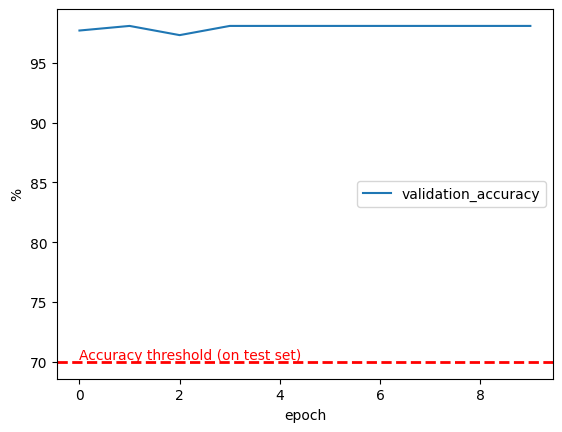

In [40]:
from pytorch_cnn import FinetuneNet
import torchvision

learning_rate = 0.01
batch_size = 64
N_epochs = 10
device = torch.device("cuda") # change if necessary

model = FinetuneNet(load_pretrained=True).to(device)
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.heads.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.model.heads.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

validation_accuracies = []
for epoch in range(1, N_epochs + 1):
    # training
    model.train()
    for i_batch, (x, y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        net_output = model(x)
        loss = F.cross_entropy(net_output, y)
        loss.backward()
        optimizer.step()

        if i_batch % 100 == 0:
            print('[TRN] Train epoch: {}, batch: {}\tLoss: {:.4f}'.format(
                epoch, i_batch, loss.item()))

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            prediction = classify(model, x)
            correct += prediction.eq(y).sum().item()
    val_accuracy = correct / len(val_loader.dataset)
    validation_accuracies.append(100. * val_accuracy)
    print('[VAL] Validation accuracy: {:.2f}%'.format(100 * val_accuracy))

    scheduler.step()

print('Training completed, final accuracy: {:.2f}%'.format(100 * val_accuracy))
torch.save(model.state_dict(), "finetuned.pt")

visualize_data([validation_accuracies], legend=['validation_accuracy'], xlabel='epoch', ylabel='%', save_filepath='pytorch_cnn_training.png', hline=70.0, hlinelabel='Accuracy threshold (on test set)')


In [43]:
torch.save(model.state_dict(), "finetuned.pt")
print(model)

FinetuneNet(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

In [44]:
new_model = FinetuneNet(load_pretrained=False)
print(new_model)
new_model.load_state_dict(torch.load('finetuned.pt', map_location=torch.device('cuda')))

FinetuneNet(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Lay

<All keys matched successfully>

Your submitted trained `FinetuneNet` network will be automatically evaluated by the [upload system](https://cw.felk.cvut.cz/brute/) and ranked in the online [leaderboard](https://cw.felk.cvut.cz/brute/data/ae/release/2020z_rpz/rpz-2020/upload_system/cnn_leaderboard.php) in real time. __Your network needs to perform better than the baseline 70% accuracy on the test set for you to pass this lab.__

Please, notice that we, as your customer, use a private test set to measure the level of generalization of your method. It consists of images taken randomly from the same distribution as the training images (part ORIG), we added a few augmented versions to test for different imaging conditions (part AUG) and finally, we collected new data, which we find little bit more challenging (part NEW). Your final accuracy is a weighted sum of accuracies over these datasets: acc = 0.6 ORIGacc + 0.3 AUGacc + 0.1 NEWacc. You will see all accuracies in the leaderboard together with the final value to better estimate where your networks need improvement.

If we see unreasonably many uploads for one student, the network could be disqualified as over-fitted to the test data!

## Dogs-and-Cats Challenge

If you fulfill all above criteria and pass all BRUTE tests, you will gain typical 6 points from this lab. However, depending on your rank in the leaderboard, you may get extra bonus points!
  * 1st place: +6 points
  * 2nd place: +5 points
  * 3rd place: +4 points
  * 4th place: +3 points
  * 5th place: +2 points
  * 6th place: +1 point

**The bonus challenge will be evaluated on Sunday, January 12th, 2025 at 23:59. Later submissions are not eligible for bonus points.**

In order to achieve the best results __experiment__!

You can try for example (in no particular order)
* adjust batch size
* make the classification head larger
* experiment with the pre-trained architectures and the tasks the architecture was pre-trained on (try to understand, how do they work)
* [improve on the optimisation algorithm](https://www.ruder.io/optimizing-gradient-descent/)
* [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
* play with different augmentations
* use GPUs to speed up the training and have more attempts (you can use the university cluster or Google Colab)
* feel free to use any trick you find online or which you invent yourself. Some possibly useful ones:
  * [A recipe for training neural networks](https://karpathy.github.io/2019/04/25/recipe/) a highly recommended practical guide to NN training by Andrey Karpathy
  * [Tips and tricks for Neural Networks](https://towardsdatascience.com/tips-and-tricks-for-neural-networks-63876e3aad1a) online paper on Towards Data Science web, Pascal Janetzky
  * [Tips and tricks to train neural networks](https://www.lri.fr/~gcharpia/deeppractice/2020/tips.pdf) Berger et al., document from Laboratoire de Recherche en Informatique
  * [Deep Learning Tips and Tricks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks) by Shervine Amidi from Standford University
  * YouTube video called [Nuts and Bolts of Applying Deep Learning](https://www.youtube.com/watch?v=F1ka6a13S9I&ab_channel=LexFridman) by Andrew Ng

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one `.zip` file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

- `cnn.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `numpy_nn.py` - containing the following implemented classes:
    - `ReLU` - REctified Linear Unit layer
    - `Linear` - Linear (aka Fully Connected) layer
    - `Sigmoid` - Logistic Sigmoid layer
    - `SE` - Squared Error loss layer
- `numpy_nn_training.png`
- `numpy_nn_classification.png`
- `pytorch_cnn.py` - containing the following implemented classes and methods:
    - `MyNet` - Your CNN model
    - `FinetuneNet` - Your finetuned model. Remember you should not be downloading any weights to initialize the network during evaluation in BRUTE.
    - `classify` - classifies data using a trained network
- `pytorch_fcnet_training.png`
- `pytorch_cnn_training.png`
- `model.pt` - trained MyNet state
- `finetuned.pt` - trained FinetuneNet state

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.